In [1]:
%matplotlib inline

## Time-domain filtering with GWpy

A quick (code only) recap of what we learned in [Part 1](1 - Open Data access with GWpy.ipynb):

In [2]:
from gwpy.io.losc import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW150914')
segment = (int(gps) - 5, int(gps) + 5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bleach/__init__.py:32: DeprecationWarning: Support for html5lib-python < 1.0.0 is deprecated.
  warnings.warn('Support for html5lib-python < 1.0.0 is deprecated.', DeprecationWarning)


Fetched 1 URLs from https://losc.ligo.org for [1126259457 .. 1126259467)
Reading data... [Done]


And this is what we end up with:

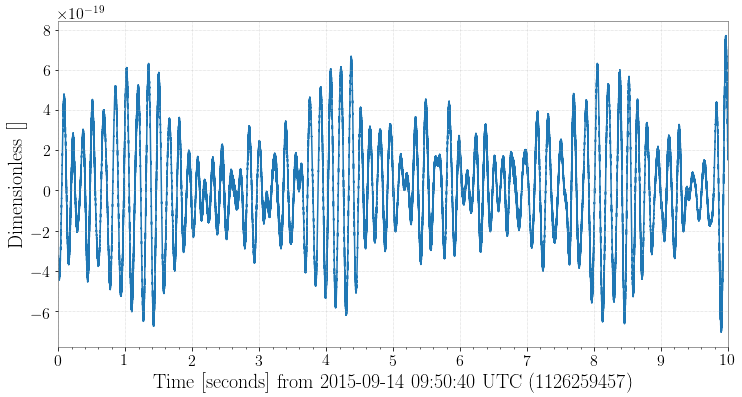

In [3]:
plot = hdata.plot()

Here we see what the unfiltered data look like; loud, low-frequency noises dominate the overall amplitude, typically caused by seismic noise.
Since the frequency of these oscillations is below the frequency-band of a gravitational-wave search, they don't have (much of) a negative impact on LIGO's detection sensitivity.

Even if we zoom the plot to right around the event time, we can't see anything obvious:

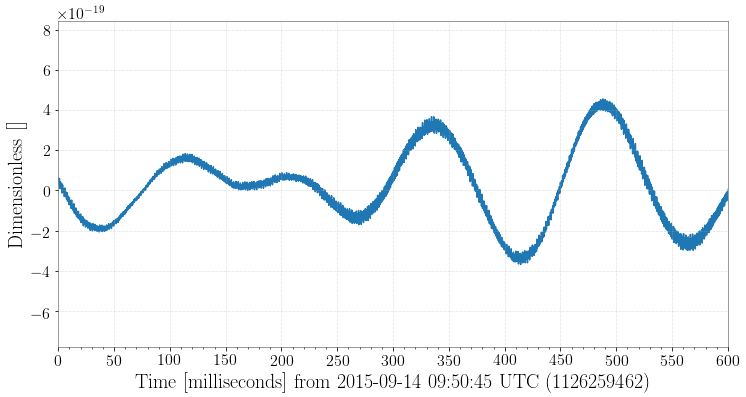

In [4]:
ax = plot.gca()
ax.set_epoch(gps)  # set T=0 on the X-axis
ax.set_xlim(gps, gps+.6)
plot

We can filter these data to remove the noises at frequencies outside of our band of interest.
GW150914 came from a 'high-mass' binary black hole merger, which was resolvable in the LIGO detectors between ~50 Hz and ~250 Hz.
For other events, this sort of bandpassing might have to be tweaked depending on the signal morphology.

In [5]:
hbp = hdata.bandpass(50, 250, filtfilt=True)

<div class="alert alert-info">
We use `filtfilt=True` to perform the filter twice, once forward in time, and once backwards. This guarantees that any phase shifts introduced by the filter response will be cancelled out in the end.
</div>

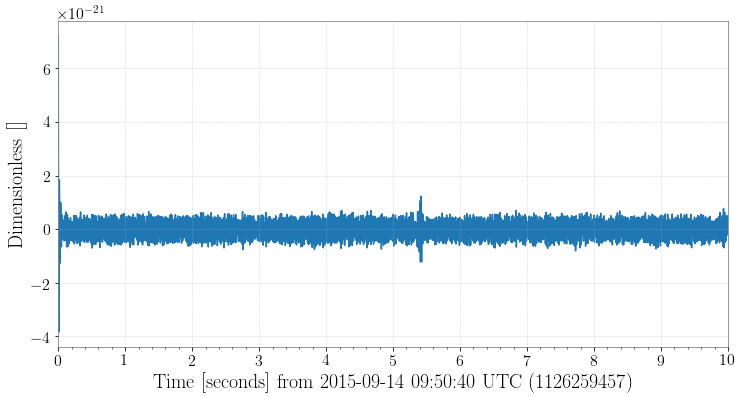

In [6]:
plot = hbp.plot()

This y-axis scaling looks a bit odd, because the amplitude right at the beginning is much higher than the rest of the data; this is because of filter settling.

However, it looks like there's a strong peak in our data, at around T=16.5 seconds! We can again zoom our plot to the time of interest:

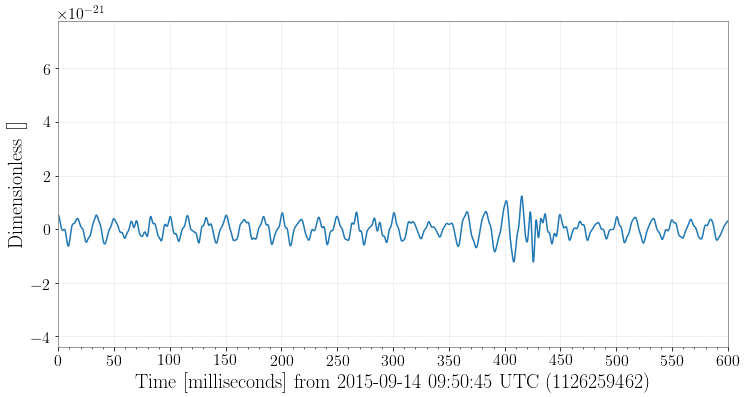

In [7]:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_xlim(gps, gps+.6)
plot

Now, that looks like a binary merger!

But the signal still looks a bit buried in the noise. More filtering! After a bit of research, we realise that there are spectral lines in the data that might be dominating. We can design a notch filter to excise power at those frequencies. Let's remove the fundamental, and the next two harmonics, of the 60 Hz US mains power supply.

<div class="alert alert-info">
There are _many_ more spectral lines present in the LIGO data, see [here](https://losc.ligo.org/o1speclines/) for more information on those. The 60 Hz power mains and harmonics are the loudest in the 50-250Hz band.
</div>

To do that we can use the [`gwpy.signal.filter_design`](https://gwpy.github.io/docs/stable/signal/#filter-design) module to design a series of [notches](https://gwpy.github.io/docs/stable/signal/#gwpy.signal.filter_design.notch):

In [8]:
from gwpy.signal import filter_design
notches = [filter_design.notch(f, hdata.sample_rate) for f in (60, 120, 180)]
powernotch = filter_design.concatenate_zpks(*notches)

Here we have used [`filter_design.contatenate_zpks`](https://gwpy.github.io/docs/stable/signal/index.html#gwpy.signal.filter_design.concatenate_zpks) to combine our three notch filters into a single filter that we can apply using [`TimeSeries.filter`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter):

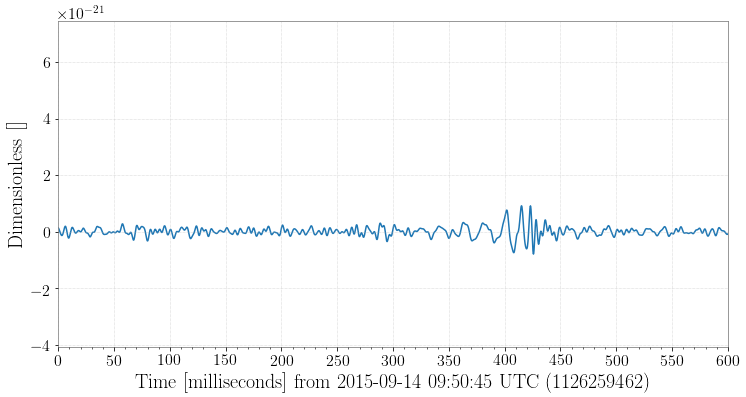

In [9]:
hclean = hbp.filter(powernotch, filtfilt=True)
plot = hclean.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_xlim(gps, gps+.6)

We see a much cleaner signal now! To finish things off, lets make a plot that looks a little better: 

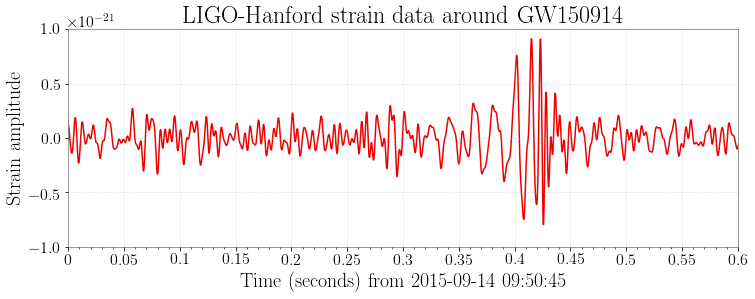

In [10]:
plot = hclean.plot(figsize=(12, 4), color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_xscale('seconds', epoch=gps)
ax.set_xlim(gps, gps+.6)
ax.set_xlabel('Time (seconds) from 2015-09-14 09:50:45')
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain amplitude')
ax.set_title('LIGO-Hanford strain data around GW150914')

Eureka! That looks like a nice, clean gravitational-wave signature, exactly what theory predicted to come from a binary black hole merger.

<div class="alert alert-warning">
This sort of time-domain filtering is _not_ used in an actual gravitational-wave search to claim detections, much more robust methods (the matched-filter) are used in those analyses.